In [53]:
import pvlib
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.location import Location
from pvlib.pvsystem import PVSystem
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np


# Set time period

In [54]:
YEAR = 2013
STARTDATE = '%d-01-01T00:00:00' % YEAR
ENDDATE = '%d-12-31T23:59:59' % YEAR
TIMES_Min = pd.date_range(start=STARTDATE, end=ENDDATE, freq='30min')
TIMES_H = pd.date_range(start=STARTDATE, end=ENDDATE, freq='H')

# Build PV system


In [55]:
# Select PV module and inverter 
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
cec_inverters = pvlib.pvsystem.retrieve_sam('CECInverter')

module = sandia_modules['Schott_Solar_ASE_250_DGF_50__250___2007__E__']
inverter = cec_inverters['ABB__PVI_3_0_OUTD_S_US__208V_']

In [49]:
location = Location(latitude=51.469, longitude=-0.105, tz='Europe/London', altitude=26, name='Elmore House')

temperature_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

system = PVSystem(surface_tilt=35, surface_azimuth=150, module_parameters=module, inverter_parameters=inverter,
                  temperature_model_parameters=temperature_parameters, modules_per_string=4, strings_per_inverter=1)


# Get poa data for 2020 (366 days)


In [33]:
poa_data_2020, meta, inputs = pvlib.iotools.get_pvgis_hourly(51.469, -0.105, start=2013, end=2013, raddatabase="PVGIS-SARAH2", components=True, surface_tilt=35,\
            surface_azimuth=-30, outputformat='json', usehorizon=True, userhorizon=None, pvcalculation=False, \
peakpower=None, pvtechchoice='crystSi', mountingplace='free', loss=0, trackingtype=0, optimal_surface_tilt=False,\
            optimalangles=False, url='https://re.jrc.ec.europa.eu/api/v5_2/', map_variables=True, timeout=30)


poa_data_2020["poa_diffuse"] = poa_data_2020["poa_sky_diffuse"] + poa_data_2020["poa_ground_diffuse"]
poa_data_2020["poa_global"] = poa_data_2020["poa_diffuse"] + poa_data_2020["poa_direct"]
poa_data_2020

,poa_direct,poa_sky_diffuse,poa_ground_diffuse,solar_elevation,temp_air,wind_speed,Int,poa_diffuse,poa_global
time,,,,,,,,,
2013-01-01 00:10:00+00:00,0.0,0.0,0.0,0.0,8.47,4.07,0,0.0,0.0
2013-01-01 01:10:00+00:00,0.0,0.0,0.0,0.0,8.16,4.34,0,0.0,0.0
2013-01-01 02:10:00+00:00,0.0,0.0,0.0,0.0,7.40,4.21,0,0.0,0.0
2013-01-01 03:10:00+00:00,0.0,0.0,0.0,0.0,6.70,3.86,0,0.0,0.0
2013-01-01 04:10:00+00:00,0.0,0.0,0.0,0.0,5.83,3.38,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2013-12-31 19:10:00+00:00,0.0,0.0,0.0,0.0,5.78,4.14,0,0.0,0.0
2013-12-31 20:10:00+00:00,0.0,0.0,0.0,0.0,5.69,4.14,0,0.0,0.0
2013-12-31 21:10:00+00:00,0.0,0.0,0.0,0.0,5.77,4.41,0,0.0,0.0


In [34]:
modelchain = ModelChain(system, location)

modelchain.run_model_from_poa(poa_data_2020)


ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: sandia_inverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

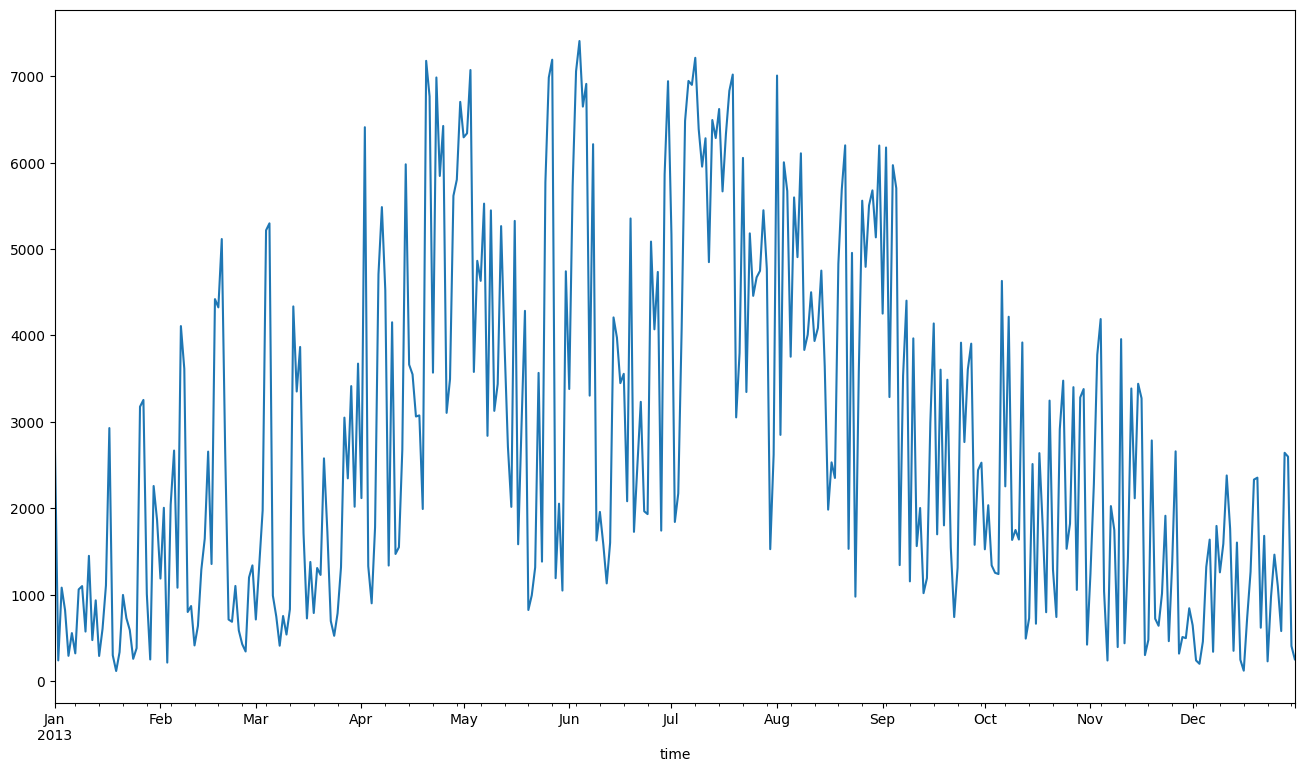

In [35]:
modelchain.results.ac.resample("D").sum().plot(figsize=(16,9))
plt.show()

In [36]:
sum_hourly_data = modelchain.results.ac.sum()
sum_hourly_data

1031033.8753076775

## Try with data from CAMS

In [9]:
poa_data_2020_cams, meta = pvlib.iotools.get_cams(51.469, -0.105, datetime(2020, 1, 1), datetime(2020, 12, 31), "ucemavg@ucl.ac.uk",
        identifier='cams_radiation', altitude=26, time_step='15min', time_ref='UT',
        verbose=False, integrated=False, label=None, map_variables=True, server='www.soda-is.com', timeout=30)


In [10]:
# resample cams data from 15 min to 30 min 

poa_data_2020_cams = poa_data_2020_cams.resample('30T').mean()

C:\Users\agorb\AppData\Local\Temp\ipykernel_13816\720995180.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  poa_data_2020_cams = poa_data_2020_cams.resample('30T').mean()


In [11]:
modelchain = ModelChain(system, location)

modelchain.run_model(poa_data_2020_cams)

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: sandia_inverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

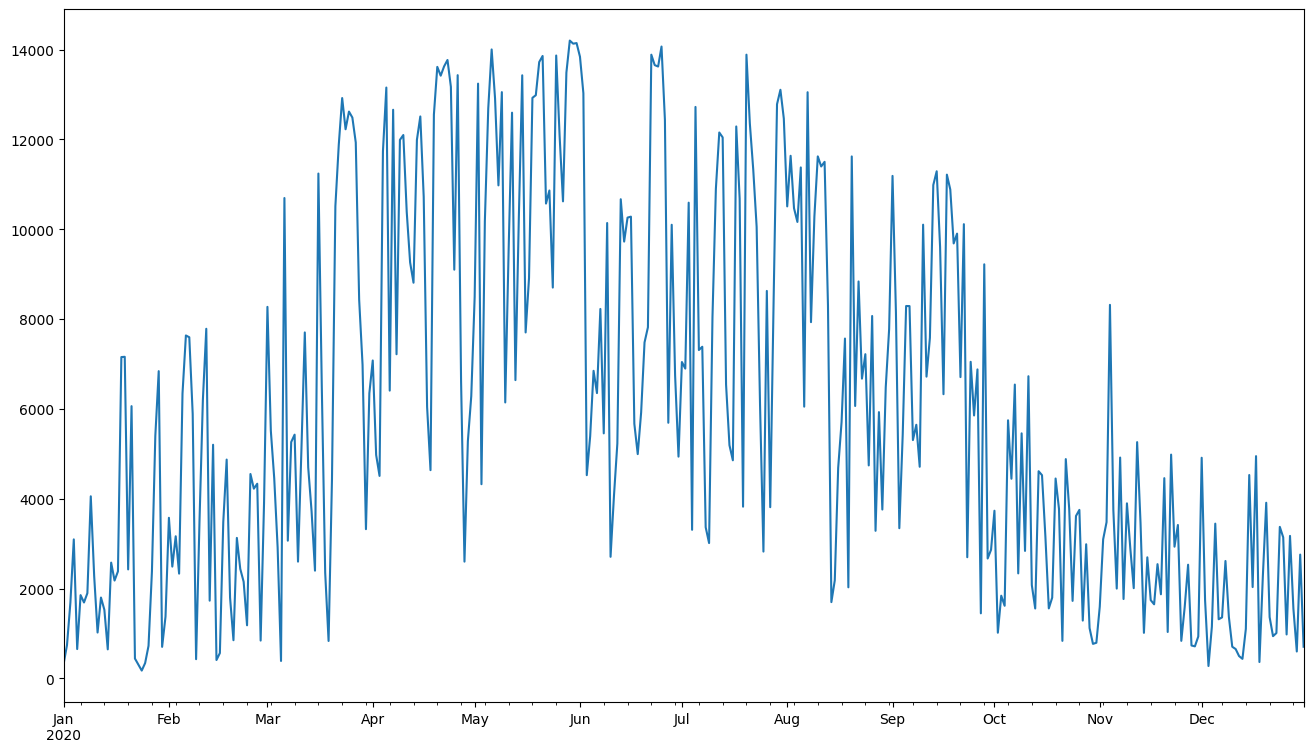

In [12]:
modelchain.results.ac.resample("D").sum().plot(figsize=(16,9))
plt.show()

In [13]:
sum_hourly_data = modelchain.results.ac.sum()
sum_hourly_data

2235344.065291936

### Export half hour kWh (kWh/hh) for 37kWp output

In [37]:
pv_output_2020 = pd.DataFrame(modelchain.results.ac, columns= ["kWh/hh"])
# divided by 2 to account for half hourly data and multiplied by 37 to receive 37kWp output
# divided by 1000 to receive kWh
pv_output_2020["kWh/hh"] = pv_output_2020["kWh/hh"]/2*37/1000 
pv_output_2020[pv_output_2020 < 0] = 0

In [38]:
pv_output_2020.index.name = 'DateTime'

In [39]:
pv_output_2020

,kWh/hh
DateTime,
2013-01-01 00:10:00+00:00,0.0
2013-01-01 01:10:00+00:00,0.0
2013-01-01 02:10:00+00:00,0.0
2013-01-01 03:10:00+00:00,0.0
2013-01-01 04:10:00+00:00,0.0
...,...
2013-12-31 19:10:00+00:00,0.0
2013-12-31 20:10:00+00:00,0.0
2013-12-31 21:10:00+00:00,0.0


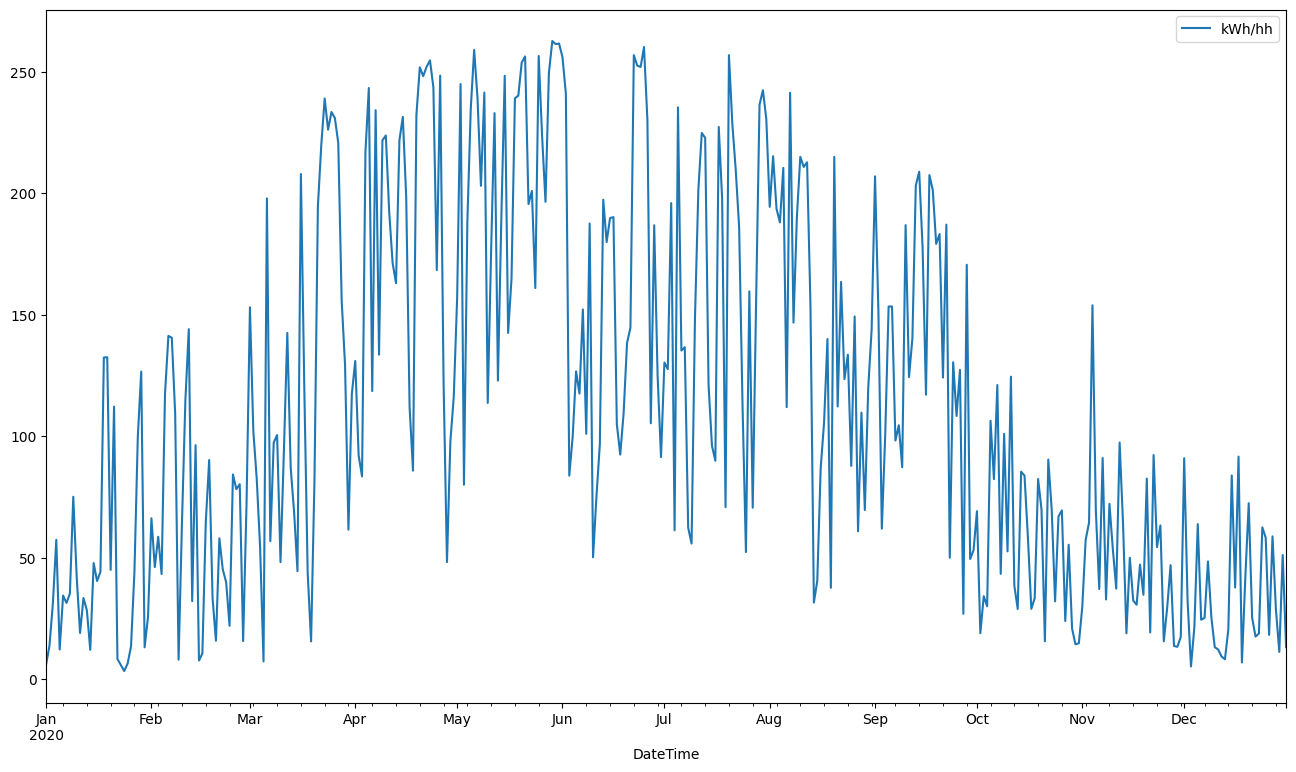

41371.70105790081

In [18]:
pv_output_2020.resample("D").sum().plot(figsize=(16,9))
plt.show()



In [41]:
TIMES_Min = pd.date_range(start=STARTDATE, end=ENDDATE, freq='30min')
TIMES_Min

DatetimeIndex(['2013-01-01 00:00:00', '2013-01-01 00:30:00',
               '2013-01-01 01:00:00', '2013-01-01 01:30:00',
               '2013-01-01 02:00:00', '2013-01-01 02:30:00',
               '2013-01-01 03:00:00', '2013-01-01 03:30:00',
               '2013-01-01 04:00:00', '2013-01-01 04:30:00',
               ...
               '2013-12-31 19:00:00', '2013-12-31 19:30:00',
               '2013-12-31 20:00:00', '2013-12-31 20:30:00',
               '2013-12-31 21:00:00', '2013-12-31 21:30:00',
               '2013-12-31 22:00:00', '2013-12-31 22:30:00',
               '2013-12-31 23:00:00', '2013-12-31 23:30:00'],
              dtype='datetime64[ns]', length=17520, freq='30T')

In [45]:
len(pv_output_2020)

8760

In [12]:
pv_output_2020.to_csv("pv_output_2020_37kWp.csv")
pv_output_2020["kWh/hh"].sum()

22085.433854573963

# Get poa data for 2020 (366 days) half hourly


In [56]:

poa_data_2020, meta, inputs = pvlib.iotools.get_pvgis_hourly(51.469, -0.105, start=2013, end=2013, raddatabase="PVGIS-SARAH2", components=True, surface_tilt=35,\
            surface_azimuth=-30, outputformat='json', usehorizon=True, userhorizon=None, pvcalculation=False, \
peakpower=None, pvtechchoice='crystSi', mountingplace='free', loss=0, trackingtype=0, optimal_surface_tilt=False,\
            optimalangles=False, url='https://re.jrc.ec.europa.eu/api/v5_2/', map_variables=True, timeout=30)


poa_data_2020["poa_diffuse"] = poa_data_2020["poa_sky_diffuse"] + poa_data_2020["poa_ground_diffuse"]
poa_data_2020["poa_global"] = poa_data_2020["poa_diffuse"] + poa_data_2020["poa_direct"]

In [57]:
poa_data_2020.index = TIMES_H
poa_data_2020

,poa_direct,poa_sky_diffuse,poa_ground_diffuse,solar_elevation,temp_air,wind_speed,Int,poa_diffuse,poa_global
2013-01-01 00:00:00,0.0,0.0,0.0,0.0,8.47,4.07,0,0.0,0.0
2013-01-01 01:00:00,0.0,0.0,0.0,0.0,8.16,4.34,0,0.0,0.0
2013-01-01 02:00:00,0.0,0.0,0.0,0.0,7.40,4.21,0,0.0,0.0
2013-01-01 03:00:00,0.0,0.0,0.0,0.0,6.70,3.86,0,0.0,0.0
2013-01-01 04:00:00,0.0,0.0,0.0,0.0,5.83,3.38,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,0.0,0.0,0.0,0.0,5.78,4.14,0,0.0,0.0
2013-12-31 20:00:00,0.0,0.0,0.0,0.0,5.69,4.14,0,0.0,0.0
2013-12-31 21:00:00,0.0,0.0,0.0,0.0,5.77,4.41,0,0.0,0.0
2013-12-31 22:00:00,0.0,0.0,0.0,0.0,6.09,4.83,0,0.0,0.0


In [58]:
poa_data_2020_30min = poa_data_2020.resample('30T').interpolate()
poa_data_2020_30min


,poa_direct,poa_sky_diffuse,poa_ground_diffuse,solar_elevation,temp_air,wind_speed,Int,poa_diffuse,poa_global
2013-01-01 00:00:00,0.0,0.0,0.0,0.0,8.470,4.070,0.0,0.0,0.0
2013-01-01 00:30:00,0.0,0.0,0.0,0.0,8.315,4.205,0.0,0.0,0.0
2013-01-01 01:00:00,0.0,0.0,0.0,0.0,8.160,4.340,0.0,0.0,0.0
2013-01-01 01:30:00,0.0,0.0,0.0,0.0,7.780,4.275,0.0,0.0,0.0
2013-01-01 02:00:00,0.0,0.0,0.0,0.0,7.400,4.210,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2013-12-31 21:00:00,0.0,0.0,0.0,0.0,5.770,4.410,0.0,0.0,0.0
2013-12-31 21:30:00,0.0,0.0,0.0,0.0,5.930,4.620,0.0,0.0,0.0
2013-12-31 22:00:00,0.0,0.0,0.0,0.0,6.090,4.830,0.0,0.0,0.0
2013-12-31 22:30:00,0.0,0.0,0.0,0.0,6.195,5.035,0.0,0.0,0.0


# Build PV system with 30 min data

In [59]:
modelchain = ModelChain(system, location)

modelchain.run_model_from_poa(poa_data_2020_30min)


ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: sandia_inverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

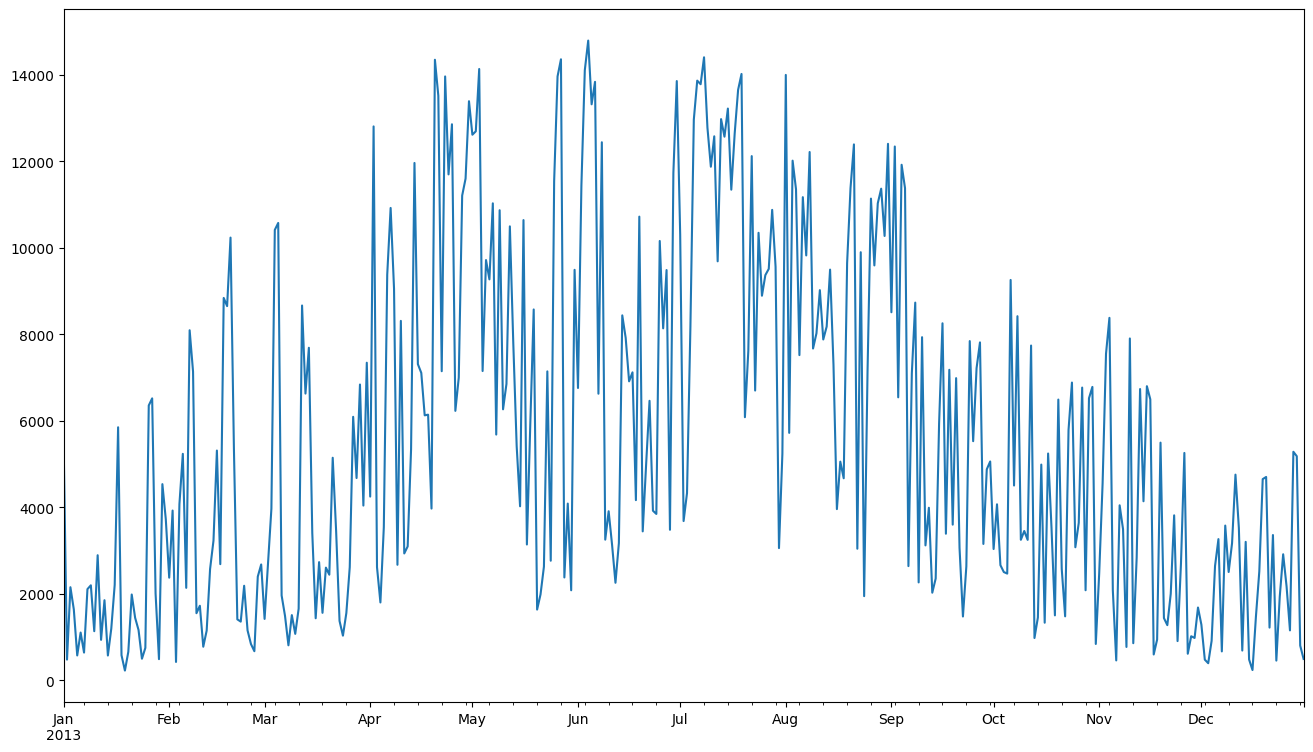

In [60]:
modelchain.results.ac.resample("D").sum().plot(figsize=(16,9))
plt.show()

In [57]:
sum_30_min_data = modelchain.results.ac.sum()

In [188]:
sum_30_min_data

2381960.9231796884